Import Libraries

In [21]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import joblib
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

sns.set(style="whitegrid")



Load Cleaned Data

In [22]:
age_cy_clean = joblib.load("../data/cleaned/age_cy_clean.pkl")
race_cy_clean = joblib.load("../data/cleaned/race_cy_clean.pkl")
gender_cy_clean = joblib.load("../data/cleaned/gender_cy_clean.pkl")

print("✅ Cleaned data loaded successfully")



✅ Cleaned data loaded successfully


Load or Generate Population Data

In [23]:
# Use synthetic or actual population data
location_year_df = gender_cy_clean[["LOCATION_ID", "CALENDAR_YEAR"]].drop_duplicates()
np.random.seed(42)
location_year_df["POPULATION"] = np.random.randint(100_000, 2_000_000, size=len(location_year_df))
population_df = location_year_df.copy()



Add Access Burden & Vulnerability Indicators

In [24]:
# --- Burden (Homeless per 1000 people) ---
def add_access_burden(df, population_df):
    merged = df.merge(population_df, on=["LOCATION_ID", "CALENDAR_YEAR"], how="left")
    merged["HOMELESS_COUNT"] = pd.to_numeric(merged["HOMELESS_COUNT"], errors="coerce")
    merged["POPULATION"] = pd.to_numeric(merged["POPULATION"], errors="coerce")
    merged["BURDEN_PER_1000"] = (merged["HOMELESS_COUNT"] / merged["POPULATION"]) * 1000
    return merged

gender_with_burden = add_access_burden(gender_cy_clean, population_df)

# --- Vulnerability (% of homeless that are youth/elderly) ---
elderly_youth = age_cy_clean[age_cy_clean["AGE_GROUP_PUBLIC"].isin(["Under 18", "65+"])]
vulnerable_summary = elderly_youth.groupby(["LOCATION_ID", "CALENDAR_YEAR"])["HOMELESS_COUNT"].sum().reset_index()
all_age_summary = age_cy_clean.groupby(["LOCATION_ID", "CALENDAR_YEAR"])["HOMELESS_COUNT"].sum().reset_index()

# Ensure numeric
vulnerable_summary["HOMELESS_COUNT"] = pd.to_numeric(vulnerable_summary["HOMELESS_COUNT"], errors="coerce")
all_age_summary["HOMELESS_COUNT"] = pd.to_numeric(all_age_summary["HOMELESS_COUNT"], errors="coerce")

vulnerability_df = vulnerable_summary.merge(
    all_age_summary,
    on=["LOCATION_ID", "CALENDAR_YEAR"],
    suffixes=("_VULN", "_TOTAL")
)

vulnerability_df["VULNERABLE_PCT"] = (
    vulnerability_df["HOMELESS_COUNT_VULN"] / vulnerability_df["HOMELESS_COUNT_TOTAL"]
) * 100

# --- Merge indicators ---
indicators_df = gender_with_burden.merge(vulnerability_df, on=["LOCATION_ID", "CALENDAR_YEAR"], how="left")



Trend-Based Features

In [25]:
indicators_df.sort_values(["LOCATION_ID", "CALENDAR_YEAR"], inplace=True)
indicators_df["YOY_CHANGE"] = indicators_df.groupby("LOCATION_ID")["HOMELESS_COUNT"].pct_change(fill_method=None)
indicators_df["ROLLING_MEAN_3YR"] = indicators_df.groupby("LOCATION_ID")["HOMELESS_COUNT"].transform(lambda x: x.rolling(window=3, min_periods=1).mean())



Clustering Counties (Unsupervised)

In [26]:
latest_year = indicators_df["CALENDAR_YEAR"].max()
cluster_df = indicators_df[indicators_df["CALENDAR_YEAR"] == latest_year].copy()

features = ["BURDEN_PER_1000", "VULNERABLE_PCT", "YOY_CHANGE", "ROLLING_MEAN_3YR"]
X = cluster_df[features].fillna(0)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

kmeans = KMeans(n_clusters=4, random_state=42)
cluster_df["CLUSTER"] = kmeans.fit_predict(X_scaled)




PCA Visualization of Clusters

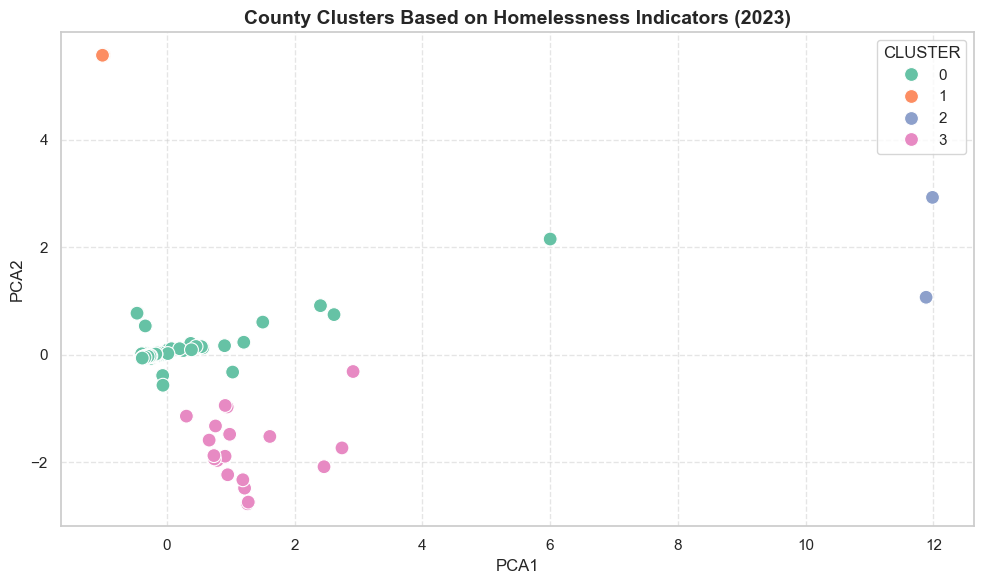

In [27]:
pca = PCA(n_components=2)
pca_components = pca.fit_transform(X_scaled)
cluster_df["PCA1"] = pca_components[:, 0]
cluster_df["PCA2"] = pca_components[:, 1]

plt.figure(figsize=(10, 6))
sns.scatterplot(data=cluster_df, x="PCA1", y="PCA2", hue="CLUSTER", palette="Set2", s=100)
plt.title("County Clusters Based on Homelessness Indicators (2023)", fontsize=14, weight="bold")
plt.grid(True, linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()




Save Clustered Data

In [ ]:
cluster_df.to_csv("../outputs/county_clusters_2023.csv", index=False)
print("✅ Clustering results saved.")

✅ Clustering results saved.
